In [2]:
import os
import numpy as np
import cv2 as cv
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
IMG_SIZE = 32
DATADIR = "archive (1)"
CATEGORIES = os.listdir(DATADIR)


In [3]:

# Get data
def create_data():
    train_images = []
    train_labels = []
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv.imread(os.path.join(path, img))
                new_array = cv.resize(img_array, (IMG_SIZE, IMG_SIZE))
                train_images.append(new_array)
                train_labels.append(class_num)
            except Exception as e:
                pass
    return np.array(train_images), np.array(train_labels)


In [28]:

train_images, train_labels = create_data()

# normalization
train_images = train_images / 255.0

# convertion of labels to one-hot encoding
train_labels = to_categorical(train_labels, num_classes=len(CATEGORIES))


In [29]:
np.save('train_images.npy', train_images)
np.save('train_labels.npy', train_labels)


In [4]:
train_images = np.load('train_images.npy')
train_labels = np.load('train_labels.npy')


In [ ]:

import time

X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# Loading VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# adding a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# adding fully-connected
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(CATEGORIES), activation='softmax')(x)

#the final model
model = Model(inputs=base_model.input, outputs=predictions)

#freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# calculating 1st phase time
start_time = time.time()

#new classifier
model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32
)

end_time = time.time()
print(f"Training Time (Phase 1): {end_time - start_time:.2f} seconds")

# unfreeze some layers of the base model and re-train for fine-tuning
for layer in base_model.layers[-5:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

start_time = time.time()

model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=14,
    batch_size=32
)

end_time = time.time()
print(f"Training Time (Phase 2): {end_time - start_time:.2f} seconds")

model.save('custom_vgg16_model.h5')


Epoch 1/20
987/987 ━━━━━━━━━━━━━━━━━━━━ 76s 76ms/step - accuracy: 0.5639 - loss: 1.0166 - val_accuracy: 0.6700 - val_loss: 0.8120
Epoch 2/20
987/987 ━━━━━━━━━━━━━━━━━━━━ 74s 75ms/step - accuracy: 0.7089 - loss: 0.7345 - val_accuracy: 0.7241 - val_loss: 0.7076
Epoch 3/20
987/987 ━━━━━━━━━━━━━━━━━━━━ 66s 67ms/step - accuracy: 0.7583 - loss: 0.6253 - val_accuracy: 0.7451 - val_loss: 0.6529
Epoch 4/20
987/987 ━━━━━━━━━━━━━━━━━━━━ 68s 68ms/step - accuracy: 0.7959 - loss: 0.5351 - val_accuracy: 0.7754 - val_loss: 0.6077
Epoch 5/20
987/987 ━━━━━━━━━━━━━━━━━━━━ 68s 68ms/step - accuracy: 0.8262 - loss: 0.4588 - val_accuracy: 0.7803 - val_loss: 0.5925
Epoch 6/20
987/987 ━━━━━━━━━━━━━━━━━━━━ 70s 71ms/step - accuracy: 0.8519 - loss: 0.3960 - val_accuracy: 0.8003 - val_loss: 0.5606
Epoch 7/20
987/987 ━━━━━━━━━━━━━━━━━━━━ 68s 68ms/step - accuracy: 0.8769 - loss: 0.3407 - val_accuracy: 0.8040 - val_loss: 0.5525
Epoch 8/20
987/987 ━━━━━━━━━━━━━━━━━━━━ 66s 67ms/step - accuracy: 0.8936 - loss: 0.2959 - 

Training Time (Phase 2): 2967.42 seconds


# confusion matrix

247/247 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step


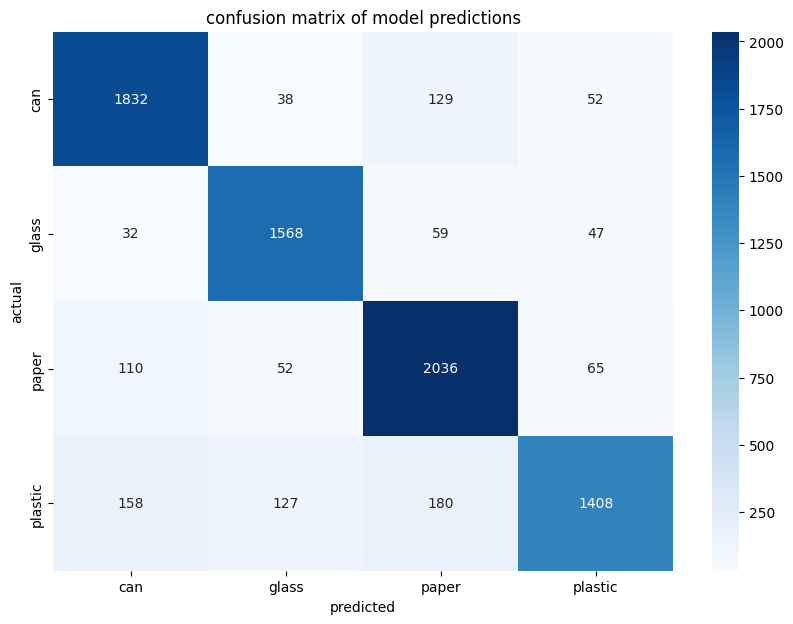

              precision    recall  f1-score   support

         can       0.86      0.89      0.88      2051
       glass       0.88      0.92      0.90      1706
       paper       0.85      0.90      0.87      2263
     plastic       0.90      0.75      0.82      1873

    accuracy                           0.87      7893
   macro avg       0.87      0.87      0.87      7893
weighted avg       0.87      0.87      0.87      7893



In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(X_val).argmax(axis=1)
y_val_labels = y_val.argmax(axis=1)


cm = confusion_matrix(y_val_labels, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('confusion matrix of model predictions')
plt.show()

print(classification_report(y_val_labels, y_pred, target_names=CATEGORIES))

# load model

In [21]:
from tensorflow.keras.models import load_model
model = load_model('custom_vgg16_model.h5')



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


array([0, 3, 2, 2, 2, 2, 2, 3, 2, 2], dtype=int64)

In [8]:
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,244,102 (58.15 MB)

 Trainable params: 7,608,836 (29.03 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

 Optimizer params: 2 (12.00 B)